Библиотеки

In [43]:
import torch.nn.functional as F
import math
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch

Механизм внимания

In [44]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        # Q (Query) - что ищу
        # K (Key) - что я предлагаю
        # V (Value) - какую информацию отдаю
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, H, L_q, L_k)

        if mask is not None:
            # расширяем маску до нужной формы
            if mask.dim() == 2:  # (seq_len, seq_len)
                mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, L_q, L_k)
            elif mask.dim() == 3:  # (batch_size, seq_len, seq_len)
                mask = mask.unsqueeze(1)  # (B, 1, L_q, L_k)

            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, V)  # (B, H, L_q, d_v)

        return output, attn_weights


Механизм многоголового внимания

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.attention = ScaledDotProductAttention(dropout)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, kv=None, mask=None, return_attention=False):
        """
        x: (B, L_q, embed_dim) - Query
        kv: (B, L_kv, embed_dim) - Key/Value. Если None, kv = x
        mask: (B,1,L_q,L_kv) или None
        """
        if kv is None:
            kv = x

        B, L_q, _ = x.size()
        L_kv = kv.size(1)

        # линейные проекции
        Q = self.q_proj(x)
        K = self.k_proj(kv)
        V = self.v_proj(kv)

        # reshape для multi-head
        Q = Q.view(B, L_q, self.num_heads, self.head_dim).transpose(1, 2)  # (B, H, L_q, head_dim)
        K = K.view(B, L_kv, self.num_heads, self.head_dim).transpose(1, 2)  # (B, H, L_kv, head_dim)
        V = V.view(B, L_kv, self.num_heads, self.head_dim).transpose(1, 2)  # (B, H, L_kv, head_dim)

        attn_output, attn_weights = self.attention(Q, K, V, mask)

        # объединяем головы
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L_q, self.embed_dim)
        output = self.out_proj(attn_output)

        if return_attention:
            return output, attn_weights
        return output


Слой кодирования позиции слова в предложении

In [46]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


FF нужен для усиления представления о каждом слове

In [47]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, x):
        return self.net(x)


Слой энеодера, выполняет mha и ff

In [48]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim):
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.ff = FeedForward(embed_dim, ff_hidden_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        attn_out = self.attention(x, mask)
        x = self.norm1(x + attn_out)

        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x


Энкодер, собранный из num_layers

In [49]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        self.layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x, mask)

        return x


Создание маски для "порционного" чтения текста

In [50]:
def causal_mask(size):
    return torch.tril(torch.ones(size, size)).unsqueeze(0)


Слой декодера для self, cross-attention и ff

In [51]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads)
        self.ff = FeedForward(embed_dim, ff_hidden_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, memory, mask=None):
        attn1 = self.self_attn(x, kv=None, mask=mask)
        x = self.norm1(x + attn1)

        attn2 = self.cross_attn(x, kv=memory)
        x = self.norm2(x + attn2)

        ff_out = self.ff(x)
        x = self.norm3(x + ff_out)
        return x


Декодер, собранный из num_layers слоёв

In [52]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        self.layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])

    def forward(self, x, memory, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x, memory, mask)
        return x


Сам трансформер

In [53]:
class Transformer(nn.Module):
    def __init__(
            self,
            vocab_size,
            embed_dim,
            num_layers,
            num_heads,
            ff_hidden_dim
    ):
        super().__init__()

        self.encoder = Encoder(
            vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim
        )
        self.decoder = Decoder(
            vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim
        )

        self.output_proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, src, tgt):
        memory = self.encoder(src)

        mask = causal_mask(tgt.size(1)).to(tgt.device)
        out = self.decoder(tgt, memory, mask)

        return self.output_proj(out)


проверка корректной работы трансформера

In [54]:
vocab_size = 50
embed_dim = 32
num_layers = 2
num_heads = 4
ff_hidden_dim = 64

model = Transformer(
    vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim
)
# создание случайных входной и целевой последовательностей
src = torch.randint(0, vocab_size, (2, 6))
tgt = torch.randint(0, vocab_size, (2, 5))

# запуск в тестовом режиме, без расчёта градиентов 
with torch.no_grad():
    logits = model(src, tgt)

print("logits shape:", logits.shape)


logits shape: torch.Size([2, 5, 50])


# Решение задачи классификации

Загрузка, токенизация и инициализация итераторов по данным

In [55]:
zip_path = "data/amazon_reviews.zip"
csv_filename = "cleaned_reviews.csv"

with ZipFile(zip_path) as z:
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

print(df.head())

df['cleaned_review'] = df['cleaned_review'].fillna("").astype(str)
df['sentiments'] = df['sentiments'].dropna().fillna("").astype(str)

texts = df['cleaned_review'].tolist()
labels = df['sentiments'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # negative=0, neutral=1, positive=2
labels_names = label_encoder.classes_

# токенизация
vocab = {'<PAD>': 0, '<UNK>': 1}
for sentence in texts:
    for word in sentence.split():
        if word not in vocab:
            vocab[word] = len(vocab)

def encode_text(text, max_len=50):
    tokens = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    tokens = tokens[:max_len]
    tokens += [0] * (max_len - len(tokens))  # паддинг
    return tokens

encoded_texts = [encode_text(t) for t in texts]

X_train, X_test, y_train, y_test = train_test_split(
    encoded_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


  sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  
0                     19           5.0  
1                     88           1.0  
2                      9           2.0  
3                     12           1.0  
4                     21           1.0  


Модификация реализованного ранее трансформера для классификации

In [56]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim, num_classes):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, num_layers, num_heads, ff_hidden_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        enc_out = self.encoder(x)
        cls_token = enc_out[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

num_classes = 3
model_cls = TransformerClassifier(len(vocab), embed_dim=32, num_layers=2, num_heads=4, ff_hidden_dim=64, num_classes=num_classes)


Обучение

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_cls.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls.parameters(), lr=1e-3)

for epoch in range(10):
    model_cls.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model_cls(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.3207
Epoch 2, Loss: 0.2862
Epoch 3, Loss: 0.2579
Epoch 4, Loss: 0.2243
Epoch 5, Loss: 0.1953
Epoch 6, Loss: 0.1718
Epoch 7, Loss: 0.1518
Epoch 8, Loss: 0.1338
Epoch 9, Loss: 0.1205
Epoch 10, Loss: 0.1047


Составление матрицы ошибок

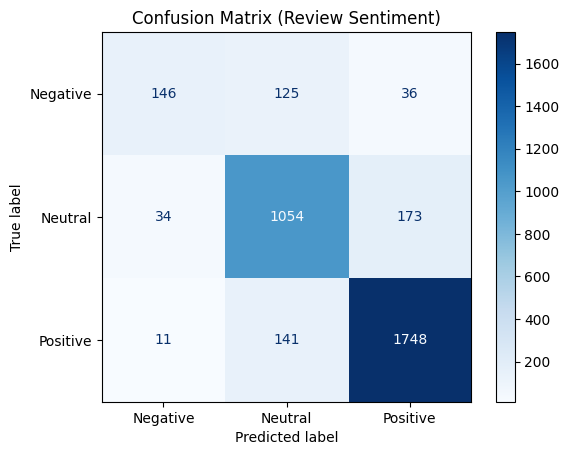

In [61]:
model_cls.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        logits = model_cls(x_batch)
        preds = torch.argmax(logits, dim=1)
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[name.capitalize() for name in labels_names])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Review Sentiment)")
plt.show()

Пример определения тональности отзыва

In [62]:
def predict_sentiment(text):
    tokens = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    max_len = 50
    tokens = tokens[:max_len] + [0]*(max_len - len(tokens))
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model_cls(input_tensor)
        pred = torch.argmax(logits, dim=1).item()
    return labels_names[pred].capitalize()

text = "This book was absolutely fantastic!"
print(f"Review: {text}")
print("Predicted sentiment:", predict_sentiment(text))

Review: This book was absolutely fantastic!
Predicted sentiment: Positive
